**Models for embeddings**

In [8]:
# pip install torch torchvision pandas pillow tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from tqdm import tqdm
import os
import numpy as np

In [9]:
# --------------------
# 1. Choose pretrained models
# --------------------
def get_model(model_name):
    if model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        embedding_size = model.fc.in_features
        model.fc = nn.Identity()
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        embedding_size = model.classifier[1].in_features
        model.classifier = nn.Identity()
    elif model_name == "vit_b_16":
        model = models.vit_b_16(pretrained=True)
        embedding_size = model.heads.head.in_features
        model.heads.head = nn.Identity()
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model = nn.Sequential(*list(model.children())[:-1])  # remove classifier
    else:
        raise ValueError(f"Unknown model: {model_name}")
    return model.eval(), embedding_size

In [10]:
# --------------------
# 2. Image preprocessing
# --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [15]:
# --------------------
# 3. Extract embeddings
# --------------------
def extract_embeddings_from_folders(model_name, good_folder, bad_folder, output_csv, device="cpu"):
    model, embedding_size = get_model(model_name)
    model.to(device)

    all_embeddings = []

    # Process good images (label=1)
    for img_name in tqdm(os.listdir(good_folder), desc=f"{model_name} - Good images"):
        img_path = os.path.join(good_folder, img_name)
        if not os.path.isfile(img_path):
            continue
        try:
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model(image_tensor).squeeze().cpu().numpy()
            row_data = [img_name, 1] + embedding.tolist()
            all_embeddings.append(row_data)
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")

    # Process bad images (label=0)
    for img_name in tqdm(os.listdir(bad_folder), desc=f"{model_name} - Bad images"):
        img_path = os.path.join(bad_folder, img_name)
        if not os.path.isfile(img_path):
            continue
        try:
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                embedding = model(image_tensor).squeeze().cpu().numpy()
            row_data = [img_name, 0] + embedding.tolist()
            all_embeddings.append(row_data)
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")

    # Save CSV
    col_names = ["name", "label"] + [f"embedding_{i+1}" for i in range(embedding_size)]
    df_out = pd.DataFrame(all_embeddings, columns=col_names)
    df_out.to_csv(output_csv, index=False)
    print(f"✅ Saved embeddings for {model_name} to {output_csv}")

In [19]:
# --------------------
# 4. Run for multiple models
# --------------------
if __name__ == "__main__":
    good_folder = "../data/good_images"   # path to good images
    bad_folder = "../data/bad_images"     # path to bad images
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # extract_embeddings_from_folders("resnet18", good_folder, bad_folder, "Choroid_Quality_Evaluation/embeddings_resnet18.csv", device)
    extract_embeddings_from_folders("resnet50", good_folder, bad_folder, "../Choroid_Quality_Evaluation/embeddings_resnet50.csv", device)
    extract_embeddings_from_folders("efficientnet_b0", good_folder, bad_folder, "../Choroid_Quality_Evaluation/embeddings_efficientnet_b0.csv", device)
    extract_embeddings_from_folders("vit_b_16", good_folder, bad_folder, "../Choroid_Quality_Evaluation/embeddings_vit_b16.csv", device)

c:\Users\Amrit\anaconda3\envs\IITH\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Amrit\anaconda3\envs\IITH\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
resnet50 - Bad images: 100%|██████████| 300/300 [00:07<00:00, 41.61it/s]


✅ Saved embeddings for resnet50 to ../Choroid_Quality_Evaluation/embeddings_resnet50.csv
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Amrit/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


c:\Users\Amrit\anaconda3\envs\IITH\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:01<00:00, 14.9MB/s]
efficientnet_b0 - Bad images: 100%|██████████| 300/300 [00:08<00:00, 34.31it/s]


✅ Saved embeddings for efficientnet_b0 to ../Choroid_Quality_Evaluation/embeddings_efficientnet_b0.csv


c:\Users\Amrit\anaconda3\envs\IITH\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\Amrit/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:27<00:00, 12.4MB/s] 
vit_b_16 - Bad images: 100%|██████████| 300/300 [00:08<00:00, 33.37it/s]


✅ Saved embeddings for vit_b_16 to ../Choroid_Quality_Evaluation/embeddings_vit_b16.csv


**Determining the number of clusters to be formed**

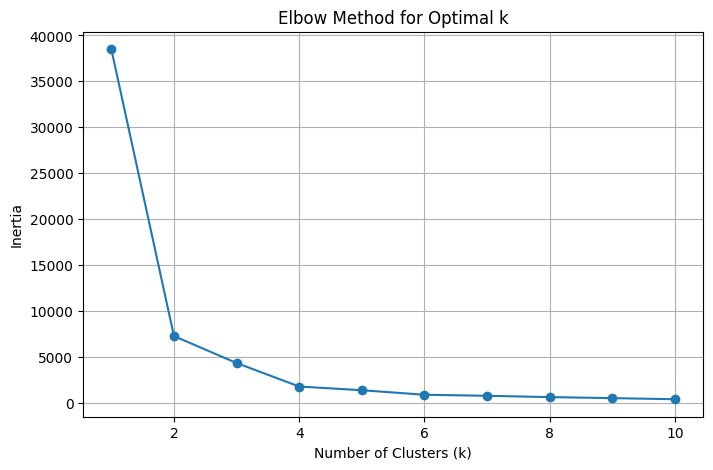

In [7]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Path to CSV file containing embeddings
csv_path = "../Choroid_Quality_Evaluation/0.Trained_embeddings/1_embeddings_umap_2d.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Remove non-numeric columns (e.g., image names)
embedding_data = df.select_dtypes(include=['float64', 'int64'])

# List to store inertia values
inertia_values = []
K_range = range(1, 11)  # Trying cluster counts from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding_data)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


Optimal number of clusters (k): 3


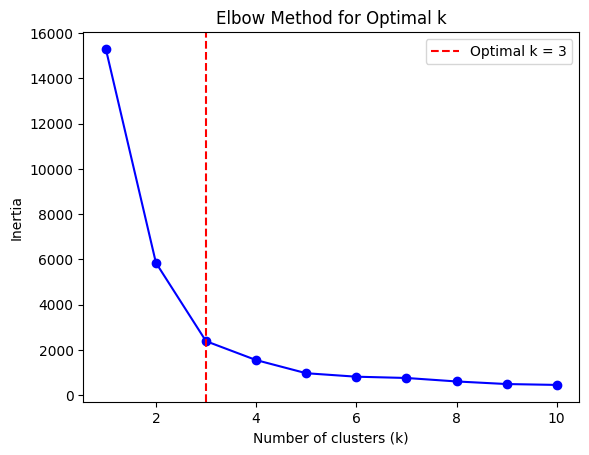

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt

# ===== Read CSV file =====
csv_file = "2.resnet50/1_embeddings_resnet50_umap_2d.csv"  # Change this to your CSV file name
df = pd.read_csv(csv_file)

# Assuming the first column is "image" or non-embedding data, drop it
# If all columns are embeddings, comment out the next line
embedding_data = df.drop(columns=[df.columns[0]]).values

# ===== Elbow Method =====
inertia_values = []
k_values = range(1, 11)  # Testing k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedding_data)
    inertia_values.append(kmeans.inertia_)

# ===== Find the "elbow" point =====
knee_locator = KneeLocator(k_values, inertia_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

print(f"Optimal number of clusters (k): {optimal_k}")

# ===== Plot Elbow Curve =====
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.show()


**Plotting the clusters**

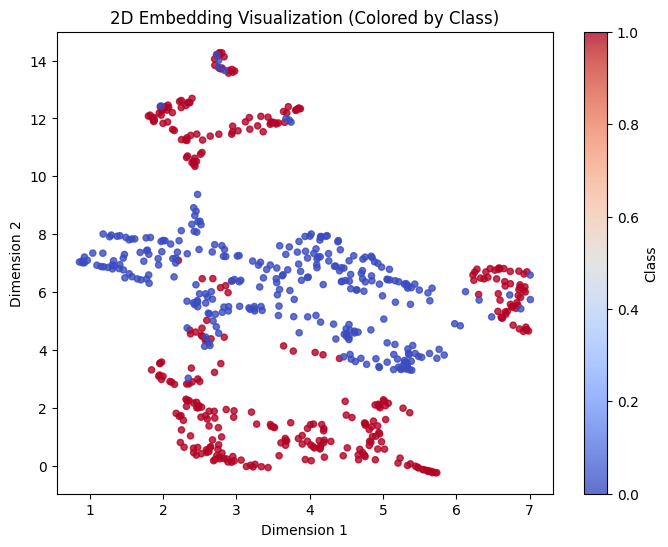

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# ===== Load Reduced CSV =====
csv_file = "3.vit_b16/1_embeddings_vit_b16_umap_2d_clusters.csv"   # change to your filename
df = pd.read_csv(csv_file)

# Extract values
x = df["umap_1"].values
y = df["umap_2"].values
labels = df["label"].values  # class labels (e.g., good/bad)

# ===== Scatter Plot =====
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    x, y, 
    c=labels, 
    cmap="coolwarm", 
    s=20, 
    alpha=0.8
)

plt.colorbar(scatter, label="Class")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("2D Embedding Visualization (Colored by Class)")
plt.show()


**Confusion Matrix**

In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ===== Paths =====
csv_file = "../trained_embeddings/org_img_cnn/image_embeddings_org_img.csv_umap_2d_clusters.csv"  # must have 'actual' and 'predicted' columns
# csv_file = csv_file[27:]
# output_dir = f"{csv_file[:csv_file.index('/')]}"  # folder to save results
output_dir = "../trained_embeddings/org_img_cnn"
os.makedirs(output_dir, exist_ok=True)  # create if not exists

# ===== Load CSV =====
df = pd.read_csv(csv_file)

# ===== Confusion Matrix =====
y_true = df["label"]
y_pred = df["cluster"]

labels = sorted(df["label"].unique())
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")

cm_path = os.path.join(output_dir, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"✅ Confusion matrix saved at: {cm_path}")

✅ Confusion matrix saved at: ../trained_embeddings/org_img_cnn\confusion_matrix.png


In [ ]:
# Confusion Matrix for 2 actual but 3 predicted clusters
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# ===== Paths =====
csv_file = "Choroid_Quality_Evaluation/3.vit_b16/1_embeddings_vit_b16_umap_2d_clusters.csv"  # must have 'actual' and 'predicted' columns
csv_file = csv_file[27:]
output_dir = f"{csv_file[:csv_file.index('/')]}"  # folder to save results
os.makedirs(output_dir, exist_ok=True)  # create if not exists

# ===== Load CSV =====
df = pd.read_csv(csv_file)

# ===== Confusion Matrix =====
y_true = df["label"]
y_pred = df["cluster"]

# take union of actual + predicted classes
labels = sorted(np.union1d(df["label"].unique(), df["cluster"].unique()))

cm = confusion_matrix(y_true, y_pred, labels=labels)

# Adjust figure size based on number of classes
num_classes = len(labels)
plt.figure(figsize=(num_classes * 3, num_classes * 2.5))

# Plot confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")

# Save confusion matrix
cm_path = os.path.join(output_dir, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.close()
print(f"✅ Confusion matrix saved at: {cm_path}")


✅ Confusion matrix saved at: 3.vit_b16\confusion_matrix.png


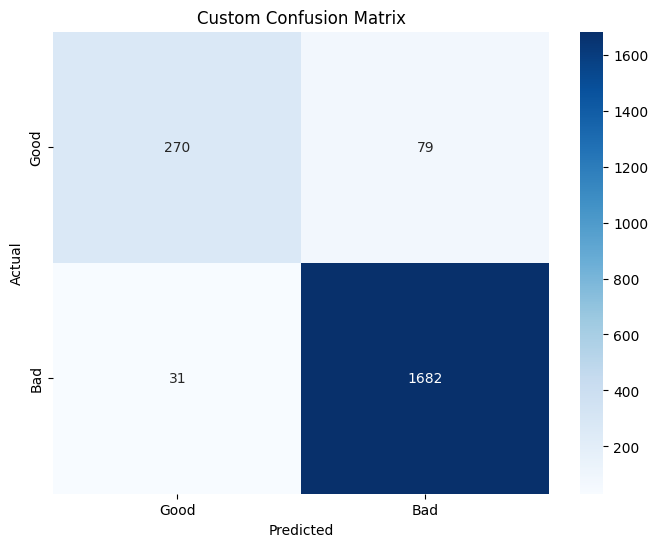

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix using your specific values
# The order is:
# True Positives (Actual Good, Predicted Good) = 305
# False Negatives (Actual Good, Predicted Bad) = 43
# False Positives (Actual Bad, Predicted Good) = 170
# True Negatives (Actual Bad, Predicted Bad) = 1543
cm_array = np.array([[270, 79],
                     [31, 1682]])

# Define the labels for the plot
labels = ['Good', 'Bad']

# Create a figure and axes for the plot
plt.figure(figsize=(8, 6))

# Use seaborn to create a heatmap for the confusion matrix
sns.heatmap(cm_array, 
            annot=True,          # Annotate cells with the matrix values
            fmt='d',             # Format the annotations as integers
            cmap='Blues',        # Use a blue color map
            xticklabels=labels,  # Label x-axis with predicted classes
            yticklabels=labels)  # Label y-axis with actual classes

# Add labels and a title to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Custom Confusion Matrix')

# Display the plot
plt.show()
